# Course Overview

**Level:** Extremely high overview.

These notes are based on [this notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) and [Chapter 1 of the Fastai](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb) book. The code is often copied verbatim.



In [ ]:
!pip install duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.8 MB/s eta 0:00:00


In [ ]:
from fastcore.all import *
from fastai.vision.all import *
from duckduckgo_search import DDGS
from fastdownload import download_url

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term)
        urls = L()
        for result in ddgs_images_gen:
            urls.append(result["image"])
            if len(urls) == max_images:
                break

    return urls

## The Big Picture

Before we do anything else, we're going to dive in and train a state of the art model. The idea here is to see the big picture.

Try to relax and take things in and see the big picture. Every step in this process, both theory and the code, we will return to in a lot more detail. And in tomorrow's class, we'll do some review of basic Python as well.

___

This model will tell us whether an image contains a bird or not. We're motivated by this xkcd comic from late 2014. Ten years ago, this was basically impossible; it is, quite literally, the punchline of a joke. Something you might write a major grant to work on. Now, we can do it for free in a few minutes.

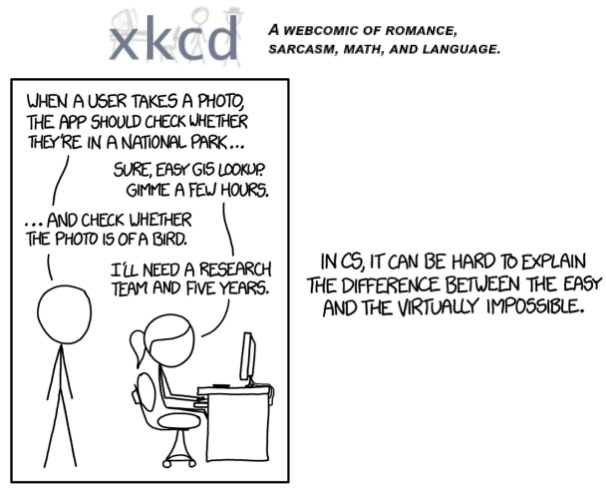

### Steps

Here's a fairly generic workflow for what we'll be doing over the course of the semester:

1. **Get a dataset.** We'll need pictures of both birds and not-birds.
2. **Train a model on the dataset.** Deep learning is all about giving data to a model, which is then allowed to learn from the data. Selecting the best model to start with is also important.
3. **Evaluate the model.** We need to assess whether or not the model has done a good job.

## Step 1: Get a Dataset

We'll use the DuckDuckGo search engine's API to download a bunch of images. First, let's make sure it's working and see whether we can get reasonable images.

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

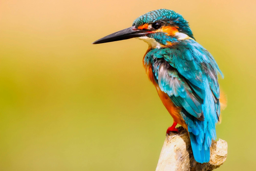

In [ ]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Yep, that's a bird. In order to know what a bird is, we need to also know what not-a-bird is. Birds are likely to be photographed in a forest, so let's use "forest" as our not-birds:

In [ ]:
urls[0]

Searching for 'forest photos'


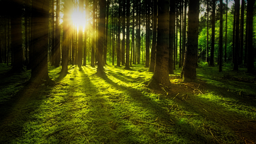

In [ ]:
urls = search_images('forest photos', max_images=5)
download_url(urls[0], 'forest.jpg', show_progress=False)

im = Image.open('forest.jpg')
im.to_thumb(256,256)

It's always good to take a look at our data as a test that everything is working properly.

Now, we'll download a bunch of forest and bird photographs and download them to our Google Colab scratch space. You'll see that in the code I've copied there are variations on "bird photo" and "forest photo" to get both bright and dark photos. You'll want your dataset to be as representative of what the conditions you intend to use the model on as possible.

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


This final step will check to see if any of the images failed to download, and remove them. You never know when your image search leads to a deleted image.

In [ ]:
get_image_files(path)

(#172) [Path('bird_or_not/forest/9ebc2f77-c5bf-4348-8383-eb1574f6f399.jpeg'),Path('bird_or_not/forest/b193fdb2-be4d-497d-994f-a8de8c0c633a.jpg'),Path('bird_or_not/forest/c8a48163-fcdc-4873-a936-d0a01f199b87.jpg'),Path('bird_or_not/forest/1cd6077e-3833-4a38-aecc-1c86a801a2ad.jpg'),Path('bird_or_not/forest/6ce7b78a-a6a1-4cff-ac47-f9afe5b543bc.jpg'),Path('bird_or_not/forest/91599b8b-1b0b-488c-9b9a-d36624f71cad.jpg'),Path('bird_or_not/forest/1563ba82-54f7-4520-8698-2832908bdfa0.jpg'),Path('bird_or_not/forest/cad8cc35-7d60-4877-a73e-47ab27bc4870.jpg'),Path('bird_or_not/forest/b304b50a-de3a-4f9b-a9be-503c8b919ced.jpg'),Path('bird_or_not/forest/3753a2dd-a35c-4a49-9fd7-a976c32b9399.jpg')...]

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

## Step 2: Train a Model

The code below creates a `DataBlock`, which is a flexible way to define and load in a dataset. If you've taken another data analytics course, your data were probably conveniently in tabular format (a spreadsheet, CSV, or similar file) or easily coerced into one. Storing data in a table is not something you can so easily do with a bunch of image files.

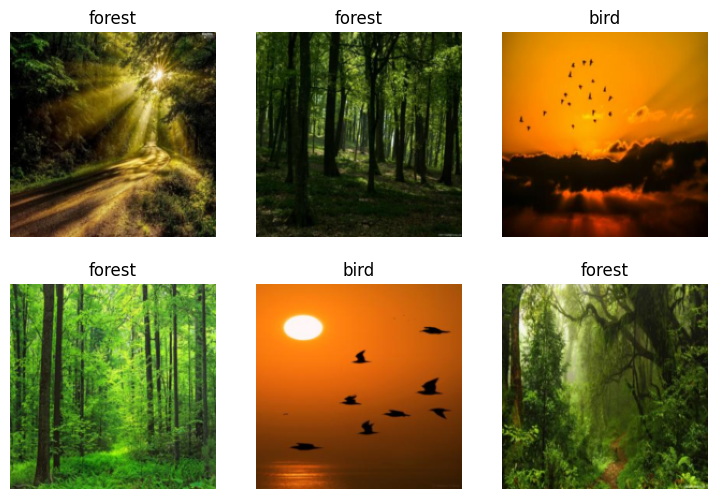

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

dls = db.dataloaders(path, bs=32)
dls.show_batch(max_n=6)

Pieces of the `DataBlock` constructor:
* We specify that there are two pieces to our model: images as inputs (`ImageBlock`), and a list of category (bird/forest) as outputs (`CategoryBlock`)
* The function `get_image_files` will be used to get each item in the dataset.
* a `RandomSplitter` randomly splits the data into training and validation sets (this is to assess overfitting—far more on this later)
* Use the function `parent_label` to get the outputs (or "y" values). That function gets the name of the folder a file is in.
* Transform the data by resizing it so that all images are 192x192 pixels. Our model will break if the images are different sizes!

From here, we create a `DataLoaders`, which will actually loads the data into the model.

Now we can fit the model! This stage is surprisingly simple. We're going to start with a `resnet18`, a very popular pre-trained image classification model, and fine-tune it to our particular bird-or-not task.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3, base_lr=0.0007)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.252141,1.549385,0.515152,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.583503,0.435511,0.151515,00:28
1,0.403189,0.075527,0.030303,00:28
2,0.284826,0.039432,0.000000,00:28


## Step 3: Evaluate Model

First, take a look at the `error_rate` from our model. (At least when I ran it) it was 0.03, which means that 3% of all images are misclassified. On the other hand, it means that 97% of them are correct. That's not bad, but hopefully we'll be able to improve with skills later in the semester.



Second, let's take a look at how well our model does on the sample images we downloaded at the beginning:

In [ ]:
category,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {category}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


Third, let's look at the worst results from the model, the ones where it's least confident (or most confidently wrong) in its answers. We can see that not all of the images we got with a simple search were perfect. Perhaps that's what's wrong. Our model can train, but you need to data.

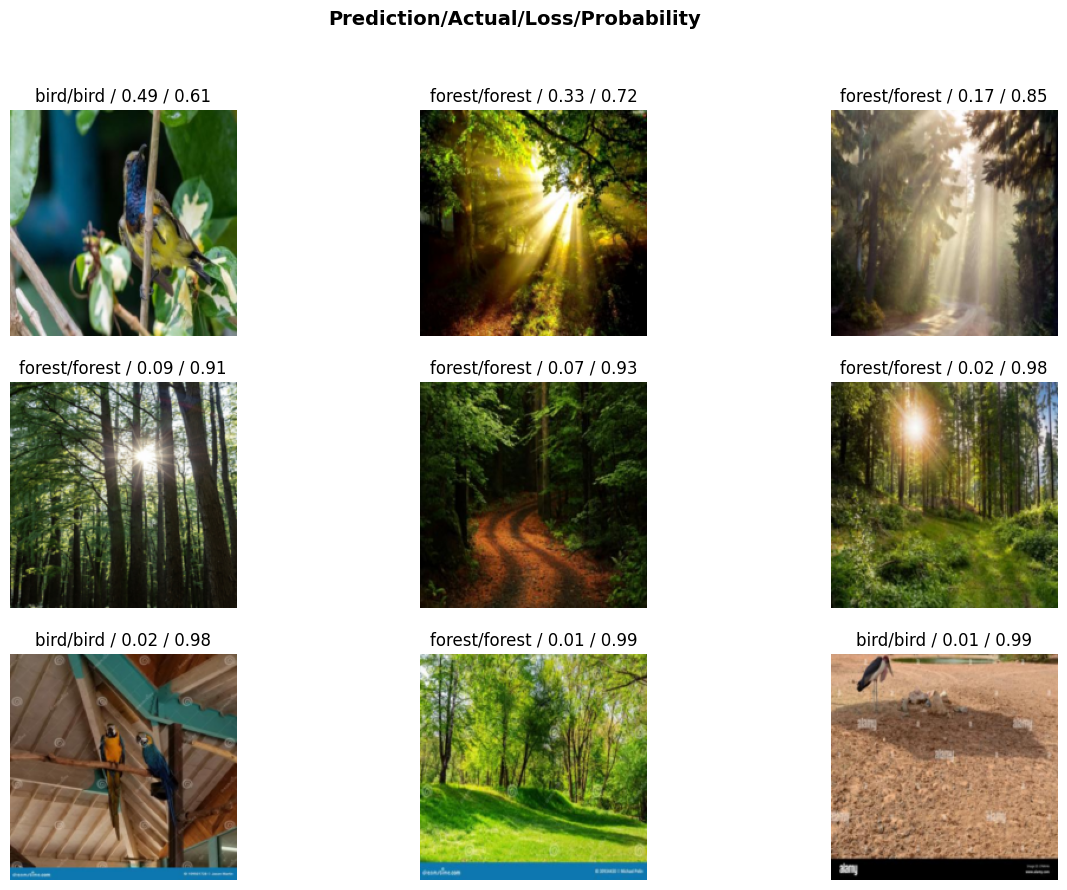

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

## Scope of this Course

Deep Learning is a constantly evolving field and even its current state is the result of over 50 years of mathematical theory, hardware optimization, and practical refinements. There are many, many different levels we could approach the deep learning in this course but simply do not have the time. Here is what I offer:

1. **Practical Skills** to train, interpret, and deploy state-of-the-art models that classify images, text, and tabular data.
2. **Theoretical Knowledge** of how modern deep learning models work at an intuitive level.
3. **From-Scratch Coding** building up to simple neural networks and embeddings.
4. **Ethical Considerations** of how deep learning has and may reshape our society.

___
*Aside:* Should you be interested, the pieces we won't be covering are:
* Implementation of code at a level lower than Python (C++ or CUDA).
* Hardware details of how GPUs speed up calculations compared with CPUs.
* Details of computation graphs and how you take symbolic derivatives.
* Details of fast matrix multiplication and linear algebra.

Covering these would require 5 more prerequisite courses: a hardware course, data structures & algrorithms, and a proofs and discrete math course (i.e. MATH 330, which also requires 2 semesters of calculus).
___

## What Else Can We Do With Deep Learning?

The method in this notebook can be used for a wide variety of tasks, including classifying trees and plants, facial recognition, eye tracking, and so on.

With [ChatGPT](https://chat.openai.com/) and [Midjourney](https://www.midjourney.com/) going mainstream, I don't think this section needs much motivation. But here are some applications across fields:

* **Accessibility:** automatic captioning; text to speech; machine translation; voice control technology (e.g. Alexa)
* **Biology and Medicine:** protein folding; mapping protein structure to function; diagnostic technology
* **Business:** market forecasting
* **Computer Vision and Robotics:** self-driving cars; image segmentation
* **Entertainment:** producing better music/TV/movie recommendations; 3D modelling water and other liquids
* **Games:** neural nets can beat humans at Go and many simple video games
* **Image Manipulation:** style transfer; text to image production; image coloration; image to video
* **Physics:** reconstructing particle interactions;
* **Text Analysis:** text classification; chatbots (duh)
